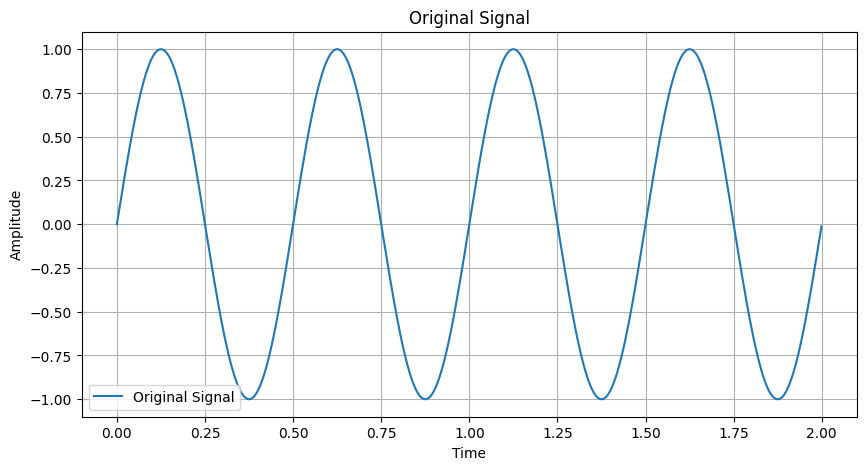

   Theoretical SQNR for 8 levels: 19.76 dB
   SQNR for 8 levels: -3.04 dB


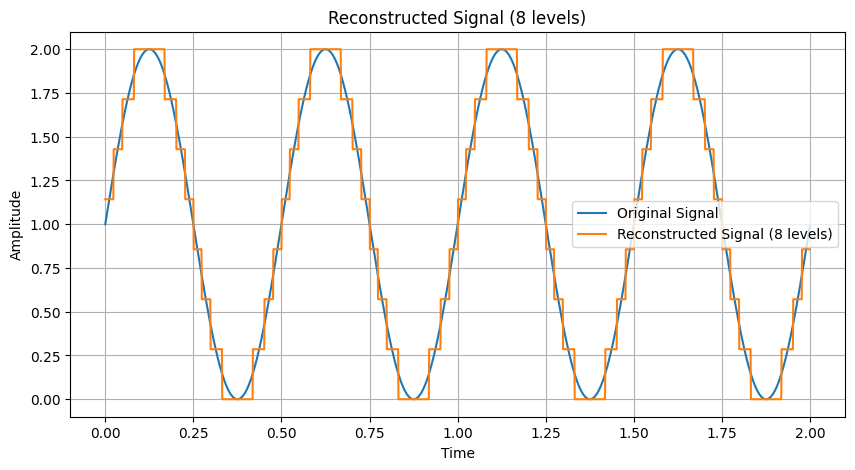

   Theoretical SQNR for 16 levels: 25.76 dB
   SQNR for 16 levels: -3.02 dB


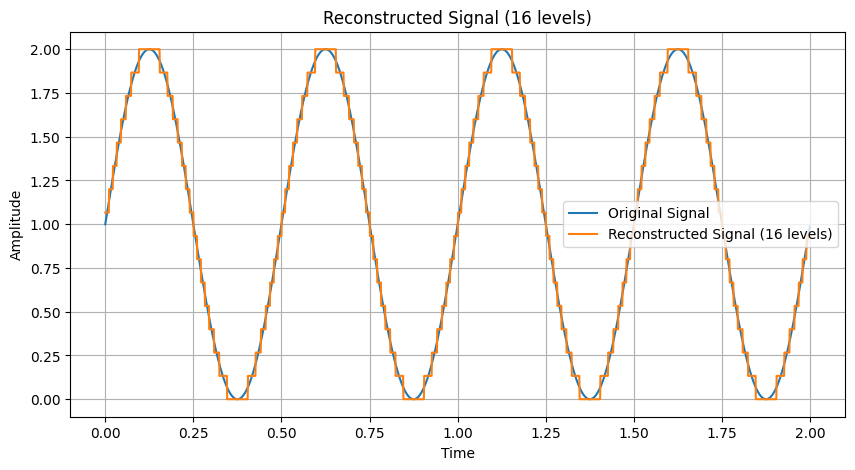

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate a sinusoidal signal
def generate_signal(amplitude, frequency, duration, sampling_freq):
    t = np.linspace(0, duration, int(duration * sampling_freq), endpoint=False)
    signal = amplitude * np.sin(2 * np.pi * frequency * t)
    return t, signal

# Function for uniform quantization
def uniform_quantization(signal, levels):
    quantized_signal = np.round((levels - 1) / 2 * (signal / max(signal)) + (levels - 1) / 2)
    return quantized_signal

# Function to calculate Signal to Quantization Noise Ratio (SQNR)
def calculate_sqnr(original_signal, quantized_signal):
    signal_power = np.mean(np.square(original_signal))
    noise_power = np.mean(np.square(original_signal - quantized_signal))
    sqnr = 10 * np.log10(signal_power / noise_power)
    return sqnr

# Function to encode quantized levels and store corresponding bits in a matrix
def encode_levels(quantized_signal, levels):
    num_bits = int(np.ceil(np.log2(levels)))
    encoded_signal = np.zeros_like(quantized_signal, dtype='U8')
    for i, level in enumerate(quantized_signal):
        encoded_signal[i] = np.binary_repr(int(level), width=num_bits)
    return encoded_signal

# Function to reconstruct the signal from encoded bits using quantization levels and original amplitude
def reconstruct_signal(encoded_signal, levels, original_amplitude):
    decoded_signal = np.zeros_like(encoded_signal, dtype=float)
    for i, code in enumerate(encoded_signal):
        decoded_signal[i] = (2 * int(code, 2) / (levels - 1)) * original_amplitude
    return decoded_signal

def theoretical_sqnr(levels):
    num_bits = int(np.ceil(np.log2(levels)))
    return 6 * num_bits + 1.76


# Parameters
amplitude = 1
frequency = 2
duration = 2  # two cycles
fs = 1000  # choose appropriate sampling frequency
quantised_levels = [8, 16]  # 8 and 16 quantization levels

# Generate the sinusoidal signal
t, original_signal = generate_signal(amplitude, frequency, duration, fs)

# Plot the original signal
plt.figure(figsize=(10, 5))
plt.plot(t, original_signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Encode, decode, and reconstruct for each quantization level
for levels in quantised_levels:
    quantised_signal = uniform_quantization(original_signal, levels)
    encoded_signal = encode_levels(quantised_signal, levels)
    reconstructed_signal = reconstruct_signal(encoded_signal, levels, amplitude)
    
    # Calculate SQNR
    sqnr = calculate_sqnr(original_signal, reconstructed_signal)
    theoretical_sqnr_val = theoretical_sqnr(levels)
    print(f"   Theoretical SQNR for {levels} levels: {theoretical_sqnr_val:.2f} dB")
    print(f"   SQNR for {levels} levels: {sqnr:.2f} dB")

    # Reconstruction plot
    original_signal_shifted = original_signal - np.min(original_signal)
    reconstructed_signal_shifted = reconstructed_signal - np.min(reconstructed_signal)
    plt.figure(figsize=(10, 5))
    plt.plot(t, original_signal_shifted, label='Original Signal')
    plt.plot(t, reconstructed_signal_shifted, label=f'Reconstructed Signal ({levels} levels)')
    plt.title(f'Reconstructed Signal ({levels} levels)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()



In [16]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

# A-law non-linear transformation function
def a_law_transform(signal, A=87.6):
    A = A  # A-law compression parameter
    compressed_signal = np.sign(signal) * (np.log1p(A * np.abs(signal)) / np.log1p(A))
    return compressed_signal

# Inverse A-law non-linear transformation function
def inverse_a_law_transform(signal, A=87.6):
    A = A  # A-law compression parameter
    expanded_signal = np.sign(signal) * ((1 / A) * (np.expm1(np.log1p(A) * np.abs(signal))))
    return expanded_signal

# Function for nonuniform quantisation
def nonuniform_quantisation(signal, levels):
    # Apply non-linear transformation to the quantization levels
    nonuniform_levels = np.linspace(-1, 1, levels)**3  # Example non-linear transformation (cubing)

    # Quantise the signal using the nonuniform levels
    quantised_signal = np.zeros_like(signal)
    for i, sample in enumerate(signal):
        quantised_signal[i] = nonuniform_levels[np.argmin(np.abs(sample - nonuniform_levels))]
    
    return quantised_signal

# Function to calculate Signal to Quantisation Noise Ratio (SQNR)
def calculate_sqnr(original_signal, quantized_signal):
    signal_power = np.mean(np.square(original_signal))
    noise_power = np.mean(np.square(original_signal - quantized_signal))
    sqnr = 10 * np.log10(signal_power / noise_power)
    return sqnr

# Load speech signal from a WAV file using librosa
input_speech_sig, fs = librosa.load('speech.wav')  # Replace 'speech.wav' with the filename of your speech signal

# Apply A-law transformation to the speech signal
compressed_signal = a_law_transform(input_speech_sig)

# Apply nonuniform quantisation to the transformed signal
quantised_levels = 32  # Number of quantization levels
non_uniform_qnt_sig = nonuniform_quantisation(compressed_signal, quantised_levels)

# Reconstruct the signal by applying the inverse A-law transformation
reconstructed_signal = inverse_a_law_transform(non_uniform_qnt_sig)

# Plot original speech signal in blue color
plt.figure(figsize=(10, 5))
plt.plot(input_speech_sig, color='brown', label='Original Speech Signal', alpha=0.5)
plt.title('Original Speech Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(reconstructed_signal, color='orange', label='Reconstructed Speech Signal', alpha=0.5)
plt.title('Reconstructed Speech Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Plot original and reconstructed signals
plt.figure(figsize=(10, 5))
plt.plot(input_speech_sig, color='blue', label='Original Speech Signal', alpha=0.8)
plt.plot(reconstructed_signal, color='orange', label='Reconstructed Speech Signal', alpha=0.8)
plt.title('Original Signal and Reconstructed Speech Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

# Ensure the original signal and quantised signals have the same length
len_min = min(len(compressed_signal), len(quantized_signal))
compressed_signal = compressed_signal[:len_min]
quantized_signal = quantized_signal[:len_min]
non_uniform_qnt_sig = non_uniform_qnt_sig[:len_min]

# Calculate SQNR for uniform PCM system
uniform_sqnr = calculate_sqnr(compressed_signal, quantized_signal)

# Calculate SQNR for nonuniform PCM system
non_uniform_sqnr = calculate_sqnr(compressed_signal, non_uniform_qnt_sig)

# Print SQNR values
print(f"SQNR for Uniform PCM: {uniform_sqnr:.2f} dB")
print(f"SQNR for Nonuniform PCM: -{non_uniform_sqnr:.2f} dB")



SQNR for Uniform PCM: -26.25 dB
SQNR for Nonuniform PCM: -23.01 dB
